## Tutorial of intervening within an attention head

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "11/15/2023"

### Overview

This tutorial shows how you can intervene at specific position within representations of a specific head. This is sort of nested interventions where you choose a head to intervene first, and then you choose a specific location, or multiple locations. 

### Set-up

In [1]:
import importlib
import sys
sys.path.append('/home/jovyan/pyreft/pyvene')

In [2]:
import pandas as pd
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RepresentationConfig,
    IntervenableConfig,
)
from pyvene import create_gpt2

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

### Factual Recall

In [3]:
config, tokenizer, gpt = create_gpt2(
    cache_dir='/home/jovyan/.cache/huggingface/hub')

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [tokenizer(base, return_tensors="pt"),
          tokenizer(source, return_tensors="pt")]

print(base)
res = gpt(**inputs[0])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

print()

print(source)
res = gpt(**inputs[1])
distrib = embed_to_distrib(gpt, res.last_hidden_state, logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

loaded model
The capital of Spain is
_Madrid              0.10501282662153244
_the                 0.09496895223855972
_Barcelona           0.07027886807918549
_a                   0.04010055586695671
_now                 0.028242478147149086
_in                  0.027600031346082687
_Spain               0.02299182489514351
_Catalonia           0.01882316544651985
_also                0.018689369782805443
_not                 0.01735646463930607

The capital of Italy is
_Rome                0.15734851360321045
_the                 0.07316380739212036
_Milan               0.04687872156500816
_a                   0.03449796512722969
_now                 0.032003406435251236
_in                  0.02306579053401947
_also                0.022748243063688278
_home                0.019202912226319313
_not                 0.01640520989894867
_Italy               0.015770718455314636


### Patch Patching on Position-aligned Tokens with in Specific Head
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

Different from the basic tutorial, this tutorial intervenes on specific locations within specific heads. For instance, we want to intervene on the last token in head 4 but not other heads.

**To do this, we need to tweak a little when we setup the intervention config.**

In [40]:
gpt.h[5].attn.c_proj.weight.shape

torch.Size([768, 768])

In [21]:
def position_in_head_config(
        model_type,
        intervention_type,
        layer):

    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,  # layer
                intervention_type,  # intervention type
                "h.pos",  # intervention unit is now [pos] within [h]
                1,  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer(
    "The capital of Spain is",
    return_tensors="pt")

sources = [tokenizer("The capital of Italy is",
                     return_tensors="pt")]

In [23]:
target_head = 0
tokens = tokenizer.encode(" Madrid Rome")
data = []

# should finish within 1 min with a standard 12G GPU
for layer_i in range(gpt.config.n_layer):

    config = position_in_head_config(
        type(gpt),
        "head_attention_value_output",
        layer_i
    )

    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {
                "sources->base": (
                    [[[[target_head]], [[pos_i]]]],  # intervene w/ target_head's pos_i
                    [[[[target_head]], [[pos_i]]]],  # intervene on target_head's pos_i
                )
            },
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"ov{layer_i}",
                    "pos": pos_i,
                    "type": "head_attention_value_output",
                }
            )

    config = position_in_head_config(
        type(gpt),
        "head_value_output",
        layer_i
    )

    intervenable = IntervenableModel(config, gpt)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base,
            sources,
            {
                "sources->base": (
                    [[[[target_head]], [[pos_i]]]],  # intervene w/ target_head's pos_i
                    [[[[target_head]], [[pos_i]]]],  # intervene on target_head's pos_i
                )
            },
        )
        distrib = embed_to_distrib(
            gpt, counterfactual_outputs.last_hidden_state, logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"v{layer_i}",
                    "pos": pos_i,
                    "type": "head_value_output",
                }
            )
df = pd.DataFrame(data)

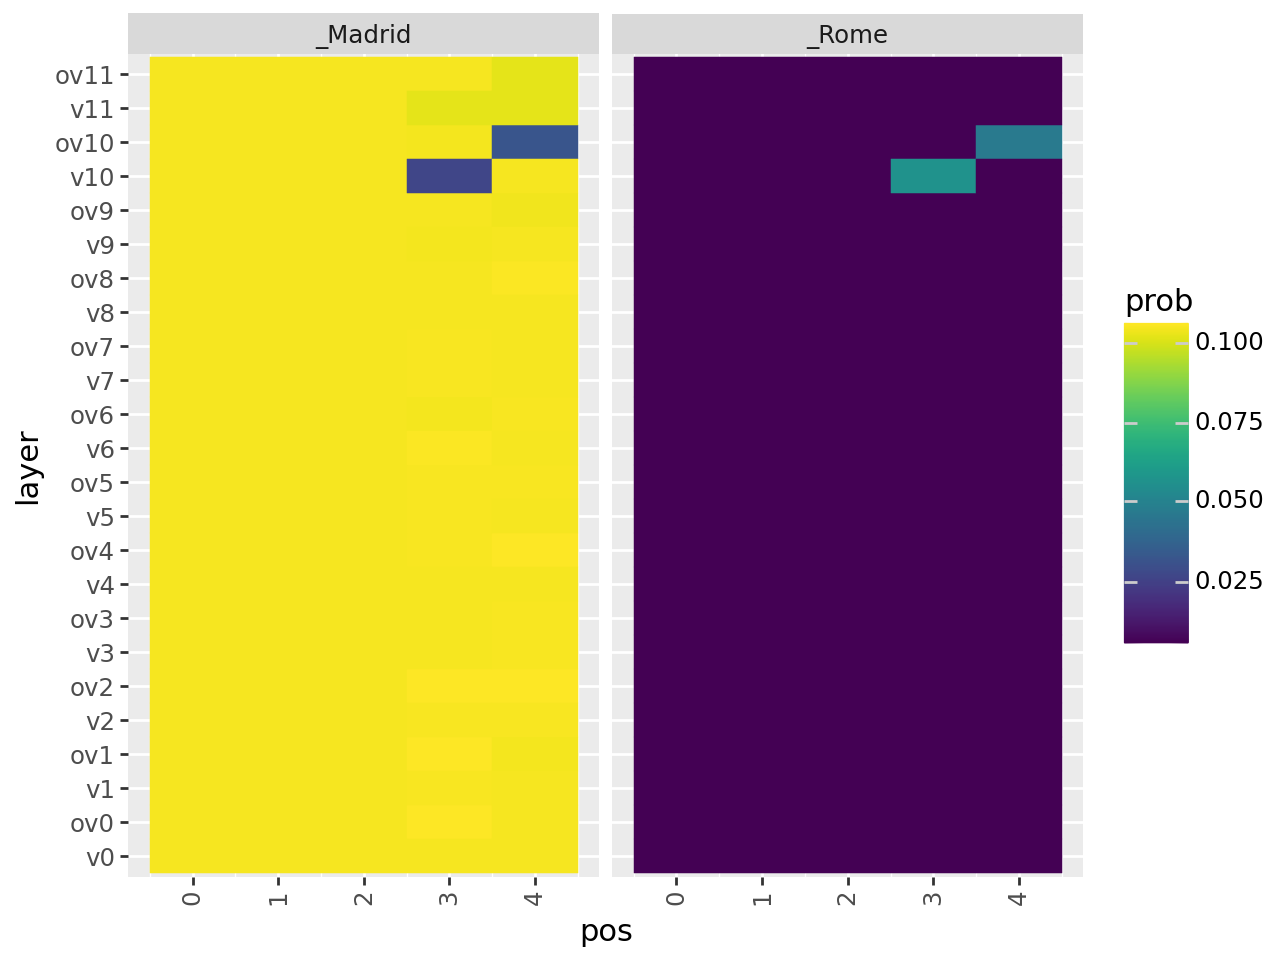

In [44]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for layer in range(gpt.config.n_layer - 1, -1, -1):
    nodes.append(f"ov{layer}")
    nodes.append(f"v{layer}")

df["layer"] = pd.Categorical(
    df["layer"],
    categories=nodes[::-1],
    ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos",
                    y="layer",
                    fill="prob",
                    color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
g.show()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


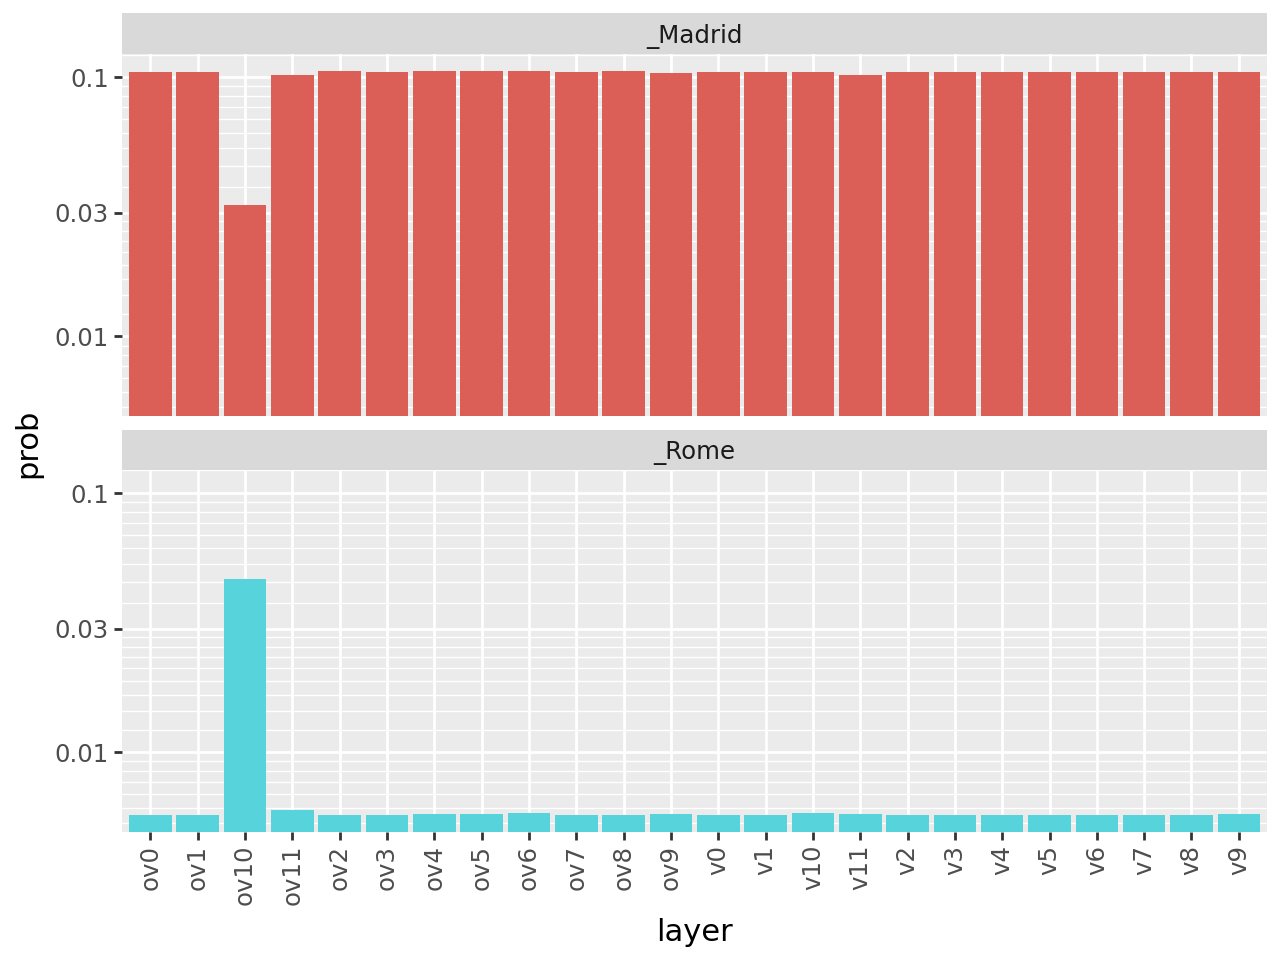

In [42]:
filtered = df
filtered = filtered[filtered["pos"] == 4]
g = (
    ggplot(filtered)
    + geom_bar(aes(x="layer", y="prob", fill="token"), stat="identity")
    + theme(axis_text_x=element_text(rotation=90), legend_position="none")
    + scale_y_log10()
    + facet_wrap("~token", ncol=1)
)
g.show()